## We can assess our metrics to see if they may be good for clustering.

In [6]:
import numpy as np 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import nibabel as nib
import sklearn.metrics as metrics
import skfuzzy as fuzz
from pca import pca

## Define folder where data lives right off the bat
base_folder = "/Users/sharada/Documents/Projects/MDDE/V3/"

### Here we want to assess our data and whether any components are redundant or the metrics we are considering are largely complementary.

In [5]:
#Empty dataframes to hold all subject's data, one dataframe per metric. Can expand as needed.
df = pd.DataFrame()
df['img_1'] = 0
df['img_2'] = 0
df['img_3'] = 0

subject_list = ["YEG_CONTROL", "LOBSTR_C011", "LOBSTR_C018", "LOBSTR_C019", "LOBSTR_C036", "LOBSTR_C037",
                "REPRO_C01", "REPRO_C02", "REPRO_C03", "REPRO_C04", "REPRO_C05", "REPRO_C07", 
                "LOBSTR_C029", "LOBSTR_C023", "LOBSTR_C009", "LOBSTR_C038", "LOBSTR_C017", "LOBSTR_C025",
                "LOBSTR_C014", "LOBSTR_C028", "LOBSTR_C020", "LOBSTR_C035", "LOBSTR_C006", "LOBSTR_C007",
                "LOBSTR_C012"]   

#Load in each subject's data
for subject in subject_list:

    ##Names of folders
    folder_mask = base_folder + subject + "/ants/CALIPR/" ##Folder containing the brain mask that excludes CSF
    folder_metrics_mwf = base_folder + subject + "/ants/CALIPR/" ##Folder containing the MWF map for the subject
    folder_metrics_tvde = base_folder + subject + "/ants/CALIPR_MDD/" ##Folder containing the uFA, CMD maps for the subject (registered to MWF space)
    folder_clustering = base_folder + subject + "/clustering_outputs/" ##Folder where clustering output will go

    ##Load in data
    mask = nib.load(folder_mask+"mask_no_csf.nii.gz").get_fdata()  ##Whole brain excluding CSF
    img_data_1 = nib.load(folder_metrics_tvde+"ufa.nii.gz").get_fdata()  ##uFA map
    img_data_2 = nib.load(folder_metrics_tvde+"cmd.nii.gz").get_fdata()  ##C_MD map
    img_data_3 = nib.load(folder_metrics_mwf+"MWF_brain_ero.nii.gz").get_fdata()  ##MWF map

    ##Wherever the mask is 1, take only that metric data into account.
    img_1_nonzero = img_data_1[mask == 1]
    img_2_nonzero = img_data_2[mask == 1]
    img_3_nonzero = img_data_3[mask == 1]

    print("Putting together data from: " + subject)

    ##Stick all of these into a dataframe for processing.
    df1 = pd.DataFrame() ##Temporary holder
    df1['img_1'] = img_1_nonzero
    df1['img_2'] = img_2_nonzero
    df1['img_3'] = img_3_nonzero
    df = pd.concat([df, df1]) ##Concatenate into main container

print(df)


Putting together data from: YEG_CONTROL
Putting together data from: LOBSTR_C011
Putting together data from: LOBSTR_C018
Putting together data from: LOBSTR_C019
Putting together data from: LOBSTR_C036
Putting together data from: LOBSTR_C037
Putting together data from: REPRO_C01
Putting together data from: REPRO_C02
Putting together data from: REPRO_C03
Putting together data from: REPRO_C04
Putting together data from: REPRO_C05
Putting together data from: REPRO_C07
Putting together data from: LOBSTR_C029
Putting together data from: LOBSTR_C023
Putting together data from: LOBSTR_C009
Putting together data from: LOBSTR_C038
Putting together data from: LOBSTR_C017
Putting together data from: LOBSTR_C025
Putting together data from: LOBSTR_C014
Putting together data from: LOBSTR_C028
Putting together data from: LOBSTR_C020
Putting together data from: LOBSTR_C035
Putting together data from: LOBSTR_C006
Putting together data from: LOBSTR_C007
Putting together data from: LOBSTR_C012
            

### Scale the data, perform PCA, get explained variance ratio, covariance matrix, eigenvalues and eigenvectors.

In [7]:
scaler = StandardScaler().fit(df)
scaled_data = scaler.transform(df)
print("Data Shape: {}\n".format(scaled_data.shape))
# print(scaled_data[0:5,:])  # Sanity check that each row is what it should be

pca = PCA(n_components=3) #Was 3
pca.fit_transform(scaled_data)
print("Explained Variance Ratio: {}\n".format(pca.explained_variance_ratio_))
print("Singular Values: {}\n".format(pca.singular_values_))

Cov = pca.get_covariance()
print("Covariance:\n{}\n".format(Cov)) ##This is actually the correlation matrix, which would be useful to show probably.

Λ, V = np.linalg.eig(Cov)
print(V)
print(Λ)
print("Eigenpair 1:\n{} {}\n".format(Λ[0], V[:,0]))
print("Eigenpair 2:\n{} {}\n".format(Λ[1], V[:,1]))
print("Eigenpair 3:\n{} {}\n".format(Λ[2], V[:,2]))

Λ = Λ.tolist()
a = round(V[0,Λ.index(max(Λ))], 2)
b = round(V[1,Λ.index(max(Λ))], 2)
c = round(V[2,Λ.index(max(Λ))], 2)

L = Λ.copy()
del L[L.index(max(L))] #Remove the highest eigval
d = round(V[0,Λ.index(max(L))], 2)
e = round(V[1,Λ.index(max(L))], 2)
f = round(V[2,Λ.index(max(L))], 2)

M = Λ.copy()
del M[M.index(max(M))] #remove the top two highest eigvals so you are only left with the last one
del M[M.index(max(M))]
g = round(V[0,Λ.index(max(M))], 2)
h = round(V[1,Λ.index(max(M))], 2)
i = round(V[2,Λ.index(max(M))], 2)
print(max(M))


## Eigenvectors are columns of pca.components_ and are necessarily perpendicular.


## From https://stackoverflow.com/questions/67199869/measure-of-feature-importance-in-pca 
#ev = np.abs(pca.components_.T).dot(pca.explained_variance_ratio_) #Importance of each of MWF/uFA/CMD weighted by explained variance ratio of the PCs
#ttl_ev = pca.explained_variance_ratio_.sum()*ev/ev.sum() #This scales it I think? Like normalizes to 1.
##Careful with the transpose. You don't want it!
##Think of the matrix as 3 colums of eigenvectors. The "explained variance" (ie variance of cov matrix, ie variance along each eigvec) is the eigenvalues.
##Here we take the dot product between the eigvec matrix and eigvals to see how important each of the original dimensions are. 
ev = np.abs(pca.components_.T).dot(pca.explained_variance_) #Importance of each of MWF/uFA/CMD weighted by explained variance (ie eigenvalues) of the PCs
ttl_ev = ev/ev.sum() #This normalizes to 1.
print(pca.components_)
print(ev)
print('Importance of metric1, 2, 3:', ttl_ev)



print("PC1 is composed of {} of μFA, {} of C_md, and {} of MWF".format(a, b, c))
print("PC2 is composed of {} of μFA, {} of C_md, and {} of MWF".format(d, e, f))
print("PC3 is composed of {} of μFA, {} of C_md, and {} of MWF".format(g, h, i))

##Explained variance ratio shows how much of data variance is due to each EIGENVECTOR. Then this code separates out how much each eigenvector is influenced by each metric.
##So in total, eigvec1 is mostly driven by uFA/CMD, eigvec2 mostly by MWF etc. 

Data Shape: (22964733, 3)

Explained Variance Ratio: [0.55537115 0.31651619 0.12811267]

Singular Values: [6185.6164026  4669.70331642 2970.8954301 ]

Covariance:
[[ 1.00000004 -0.61222018  0.16558658]
 [-0.61222018  1.00000004 -0.10204728]
 [ 0.16558658 -0.10204728  1.00000004]]

[[-0.68684278  0.7133159  -0.13938226]
 [ 0.67322978  0.69666848  0.24781988]
 [-0.27387708 -0.07637701  0.95872723]]
[1.66611351 0.38433802 0.9495486 ]
Eigenpair 1:
1.6661135117994694 [-0.68684278  0.67322978 -0.27387708]

Eigenpair 2:
0.38433802130186695 [ 0.7133159   0.69666848 -0.07637701]

Eigenpair 3:
0.9495485975337705 [-0.13938226  0.24781988  0.95872723]

0.38433802130186695
[[ 0.68684278 -0.67322978  0.27387708]
 [-0.13938226  0.24781988  0.95872723]
 [-0.7133159  -0.69666848  0.07637701]]
[1.55086269 1.62475043 1.39602299]
Importance of metric1, 2, 3: [0.33923581 0.35539802 0.30536617]
PC1 is composed of -0.69 of μFA, 0.67 of C_md, and -0.27 of MWF
PC2 is composed of -0.14 of μFA, 0.25 of C_md, and

### Make a Scree plot to show how many principal components are needed to explain the variance in the data

0     55.537115
1     87.188733
2    100.000000
Name: Eigvals, dtype: float64


Text(0.5, 1.0, 'Explained Variance Ratio')

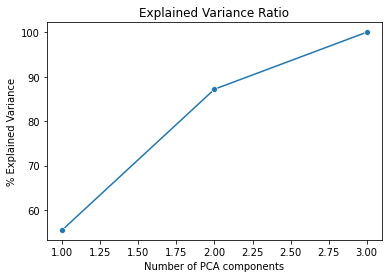

In [8]:
##Scree plot to show how many principal components we need using the explained variance ratio
screedata = pd.DataFrame()
screedata['Eigvals'] = np.cumsum(pca.explained_variance_ratio_)*100
print(screedata['Eigvals'])
screedata['pcacomponents'] = [1,2,3]
g = sns.lineplot(data=screedata, x='pcacomponents', y='Eigvals', marker='o')
g.set_xlabel('Number of PCA components')
g.set_ylabel('% Explained Variance')
g.set_title("Explained Variance Ratio")
#plt.savefig('/Users/sharada/Documents/Projects/MDDE/V3/Plots/screeplot.png', bbox_inches='tight', dpi=300)

### Biplot plot to visualize the drivers of each principal component

Data Shape: (22964733, 3)

[[ 0.68684278 -0.67322978  0.27387708]
 [-0.13938226  0.24781988  0.95872723]
 [-0.7133159  -0.69666848  0.07637701]]
[ 0.68684278 -0.67322978  0.27387708]
[0. 0. 0.]


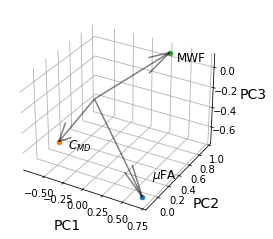

In [9]:
## Making a biplot, with the components dominating each vector indicated.
feature_names = [r'$\mu$FA', r'$C_{MD}$', 'MWF']

scaler = StandardScaler().fit(df)
scaled_data = scaler.transform(df)
print("Data Shape: {}\n".format(scaled_data.shape))
# print(scaled_data[0:5,:])  # Sanity check that each row is what it should be

pca = PCA(n_components=3) #Was 3
pca.fit_transform(scaled_data)

# Initialize the 3D graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the x, y, z variables
loadings = pca.components_
print(loadings)
xs = loadings[0]
ys = loadings[1]
zs = loadings[2]

print(xs)

# # Plot the loadings
# for i, varnames in enumerate(feature_names): #Goes through 0:uFA, 1:CMD, 2:MWF and plots each of our PCA unit vector endpoints. Why does it associate them with those feature names though?
#     print(i, varnames)
#     print(xs[i], ys[i], zs[i])
#     ax.scatter(xs[i], ys[i], zs[i], s=20) #point out position of tip of each eigenvector?
#     ax.text(
#         xs[i] + 0.1, 
#         ys[i] + 0.1, 
#         zs[i] + 0.1, 
#         varnames, fontsize=12)


ax.scatter(xs[0], ys[0], zs[0], s=20)
ax.text(xs[0]+0.15, ys[0]-0.05, zs[0]+0.25, feature_names[0], fontsize=12)
ax.scatter(xs[1], ys[1], zs[1], s=20)
ax.text(xs[1]+0.0, ys[1]+0.15, zs[1]-0.15, feature_names[1], fontsize=12)
ax.scatter(xs[2], ys[2], zs[2], s=20)
ax.text(xs[2]+0.0, ys[2]+0.15, zs[2]-0.15, feature_names[2], fontsize=12)

# Plot the arrows
x_arr = np.zeros(len(loadings[0]))
print(x_arr)
y_arr = z_arr = x_arr
plt.quiver(x_arr, y_arr, z_arr, xs, ys, zs, color=['black','black','black'], alpha=0.5)
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_zlabel('PC3', fontsize=14)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax.set_title('Loading plot of relationship between metrics and PCA space')
ax.tick_params(length=0, pad=0, direction='in')
#plt.savefig('/Users/sharada/Documents/Projects/MDDE/V3/Plots/loadingplot.png', bbox_inches='tight', dpi=300)

## In the loading plot, axes are PCs and the 3 projections of metrics are drawn as arrows. Can also add their "weighting" (ie for each component, the max contribution to a PC). 
## Here the 3 metrics look pretty different/unrelated to each other and to the PCs, but MWF is more related to PC2, CMD more to PC3, uFA to PC1.
## So it seems that each of the PCs is most influenced by a different metric! Combined with Scree plot, we would need 3 components to describe data so our 3 metrics are important.